#### Example 1 - WHPA
- All the details about the example can be found in [arXiv:2105.05539](https://arxiv.org/abs/2105.05539), and the code in `skbel/examples/demo.py`.
- It concerns a hydrogeological experiment consisting of predicting the wellhead protection area (WHPA) around a pumping well from measured breakthrough curves at said pumping well.
- Predictor and target are generated through forward modeling from a set of hydrogeological model with different hydraulic conductivity fields (not shown).
- The predictor is the set of breakthrough curves coming from 6 different injection wells around the pumping well.
- The target is the WHPA.

For this example, the data is already pre-processed. We are working with 400 examples of both `d` and `h` and consider one extra pair to be predicted. See details in the reference.

In [1]:
import os
from os.path import join as jp

import joblib
import pandas as pd

from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer

import demo_visualization as myvis
from skbel.goggles import pca_vision, cca_vision

from skbel import utils
from skbel.learning.bel import BEL

#### Building the BEL model
In this package, a BEL model consists of a succession of Pipelines (imported from scikit-learn).
We can define a function that returns our desired BEL model.
- The ```X_pre_processing``` and ```Y_pre_processing``` objects are pipelines which will first scale the data for predictor and target, then apply the dimension reduction through PCA.

- The ```X_post_processing``` and ```Y_post_processing``` objects are pipelines which will normalize predictor and target CV's.

- Finally, the BEL model is constructed by passing as arguments all these pipelines in the `BEL` object.

In [2]:
def init_bel():
    """
    Set all BEL pipelines. This is the blueprint of the framework.
    """
    # Pipeline before CCA
    X_pre_processing = Pipeline(
        [
            ("scaler", StandardScaler(with_mean=False)),
            ("pca", PCA(n_components=50)),
        ]
    )
    Y_pre_processing = Pipeline(
        [
            ("scaler", StandardScaler(with_mean=False)),
            ("pca", PCA(n_components=30)),
        ]
    )

    # Canonical Correlation Analysis
    cca = CCA(n_components=30)

    # Pipeline after CCA
    X_post_processing = Pipeline(
        [("normalizer", PowerTransformer(method="yeo-johnson", standardize=True))]
    )
    Y_post_processing = Pipeline(
        [("normalizer", PowerTransformer(method="yeo-johnson", standardize=True))]
    )

    # Initiate BEL object
    bel_model = BEL(
        X_pre_processing=X_pre_processing,
        X_post_processing=X_post_processing,
        Y_pre_processing=Y_pre_processing,
        Y_post_processing=Y_post_processing,
        cca=cca,
    )

    return bel_model

In [3]:
data_dir = jp(os.getcwd(), "dataset")
# Directory in which to unload forecasts
sub_dir = jp(os.getcwd(), "results")

# Folders
obj_dir = jp(sub_dir, "obj")  # Location to save the BEL model
fig_data_dir = jp(sub_dir, "data")  # Location to save the raw data figures
fig_pca_dir = jp(sub_dir, "pca")  # Location to save the PCA figures
fig_cca_dir = jp(sub_dir, "cca")  # Location to save the CCA figures
fig_pred_dir = jp(sub_dir, "uq")  # Location to save the prediction figures

# Creates directories
[
    utils.dirmaker(f, erase=True)
    for f in [
        obj_dir,
        fig_data_dir,
        fig_pca_dir,
        fig_cca_dir,
        fig_pred_dir,
    ]
];

[1, 1, 1, 1, 1]

#### Load the dataset
- The example dataset is saved as pandas DataFrame in `skbel/examples/dataset`.
- An arbitrary choice has to be made on the number of PC to keep for the predictor and the target. In this case, they are set to 50 and 30, respectively.
- The CCA operator `cca` is set to keep the maximum number of CV possible (30).
- The variable `y_test` is the unknown target to predict. It is ignored during the training.

In [4]:
X_train = pd.read_pickle(jp(data_dir, "X_train.pkl"))
X_test = pd.read_pickle(jp(data_dir, "X_test.pkl"))
y_train = pd.read_pickle(jp(data_dir, "y_train.pkl"))
y_test = pd.read_pickle(jp(data_dir, "y_test.pkl"))

#### Initiate BEL model

In [5]:
model = init_bel()


#### Set model parameters

In [6]:
model.mode = "mvn"  # How to compute the posterior conditional distribution
# Save original dimensions of both predictor and target
model.X_shape = (6, 200)  # Six curves with 200 time steps each
model.Y_shape = (1, 100, 87)  # One matrix with 100 rows and 87 columns
# Number of samples to be extracted from the posterior distribution
model.n_posts = 400

#### Train the model

In [7]:
# Fit BEL model
model.fit(X=X_train, Y=y_train);

#### Infer the posterior distribution

In [8]:
# The posterior distribution is computed within the method below.
model.predict(X_test);

#### Save the fitted BEL model

In [9]:
joblib.dump(model, jp(obj_dir, "bel.pkl"))

['/Users/robin/PycharmProjects/SKBEL/skbel/examples/results/obj/bel.pkl']

#### Visualization

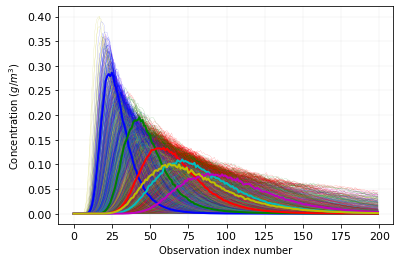

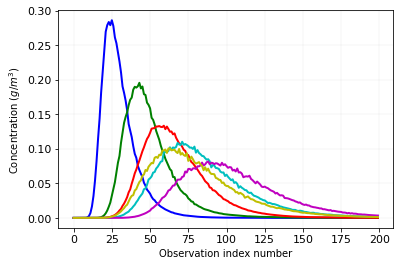

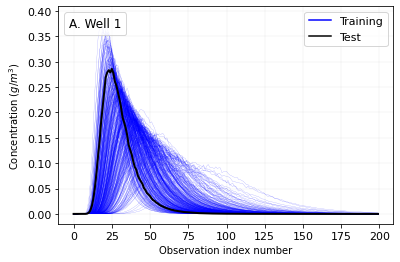

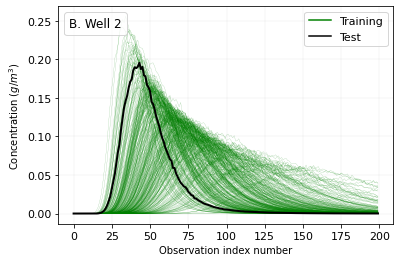

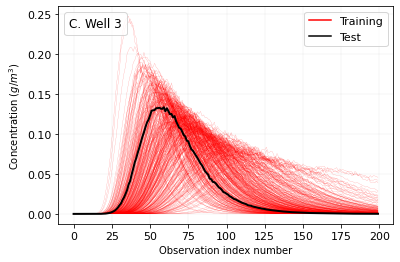

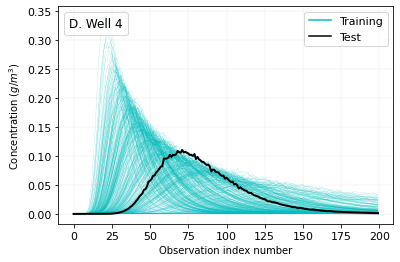

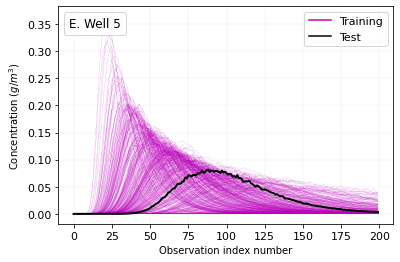

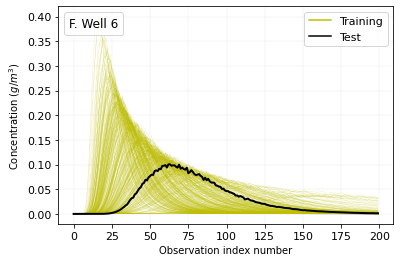

In [10]:
myvis.plot_results(
    model, X=X_train, X_obs=X_test, Y=y_train, Y_obs=y_test, base_dir=sub_dir, show=True
)

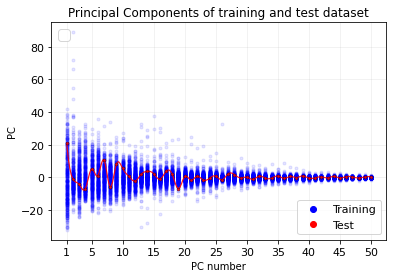

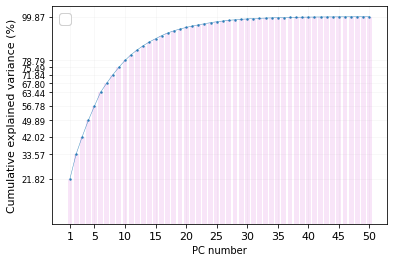

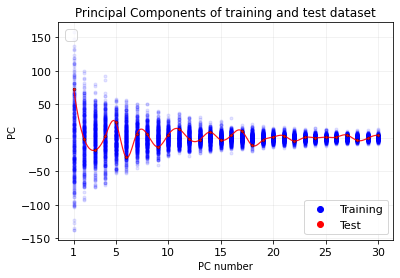

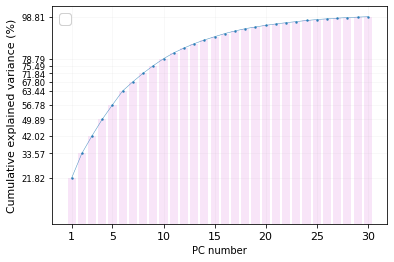

In [11]:
pca_vision(
    model,
    Y_obs=y_test,
    fig_dir=fig_pca_dir,
    show=True
)

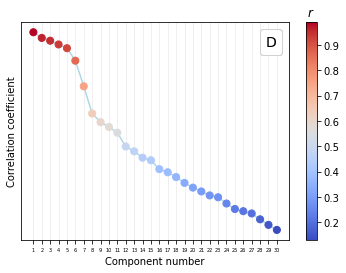

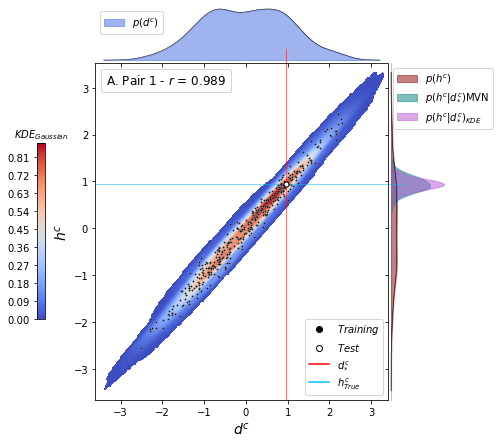

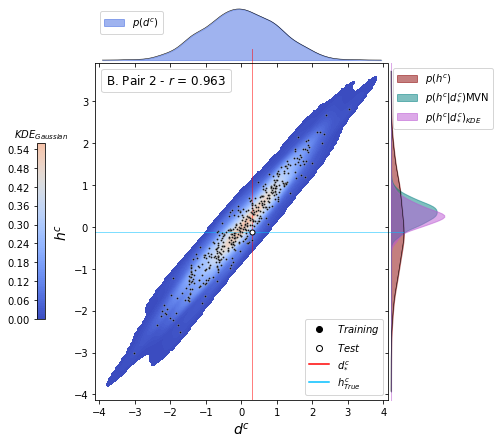

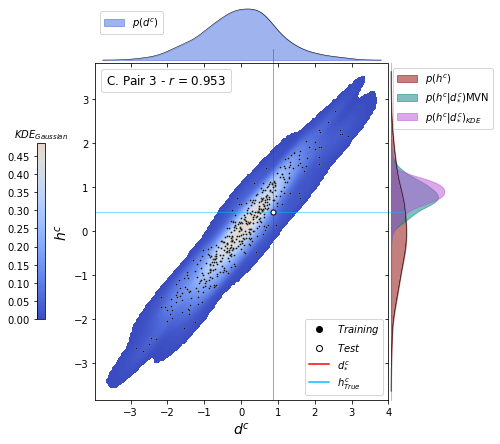

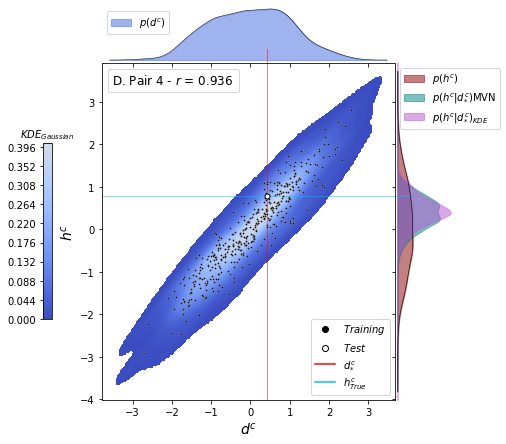

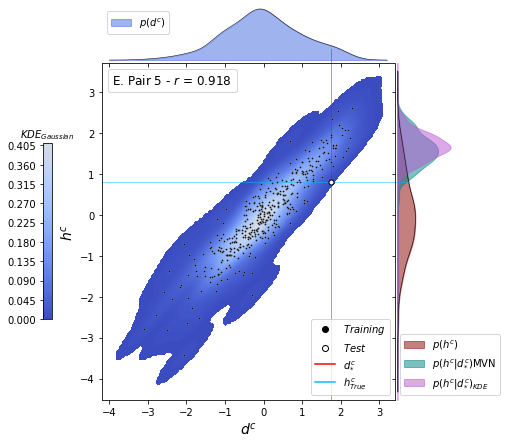

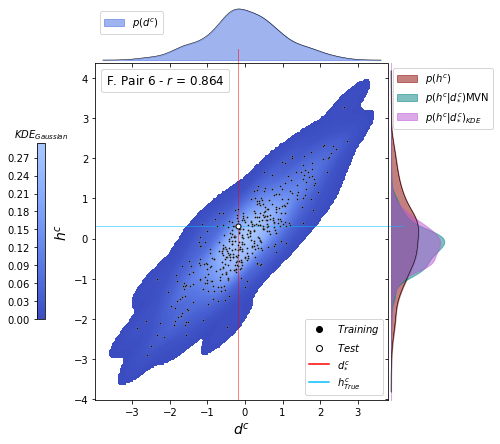

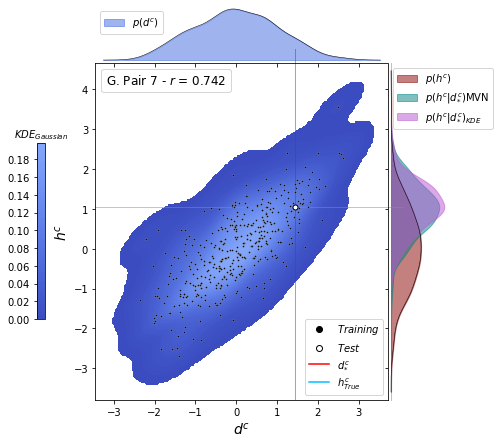

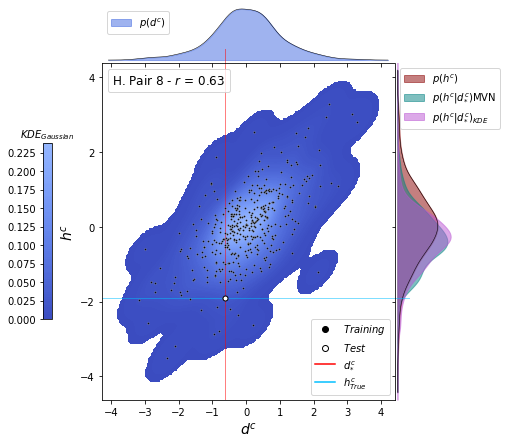

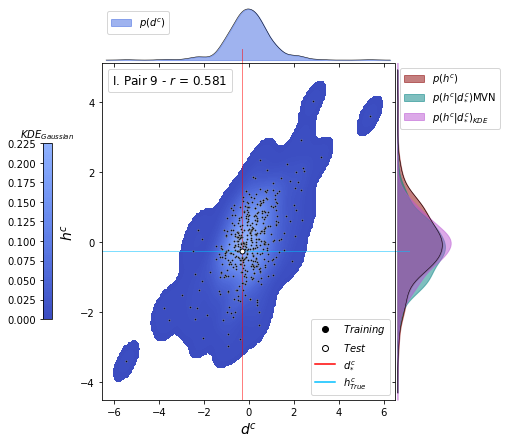

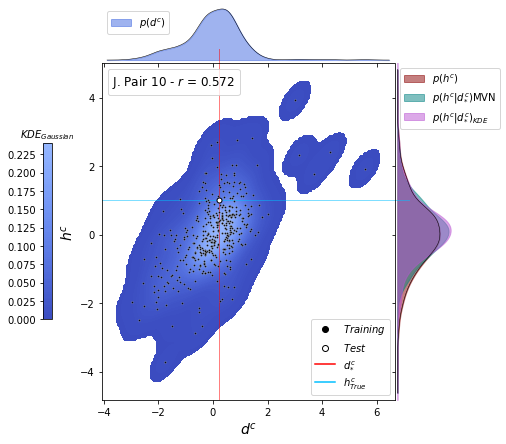

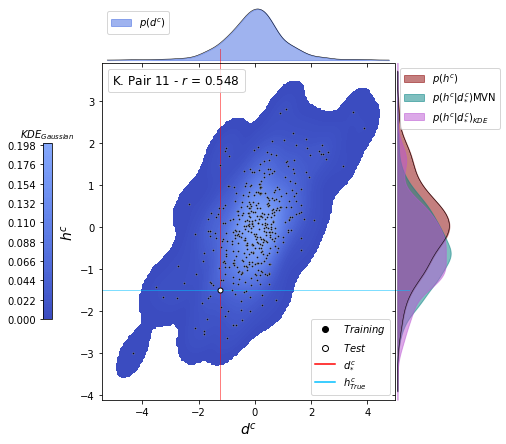

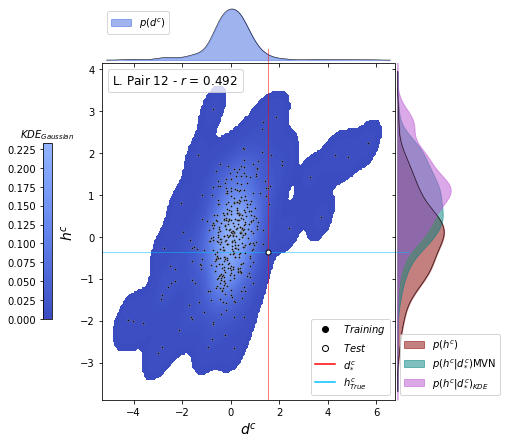

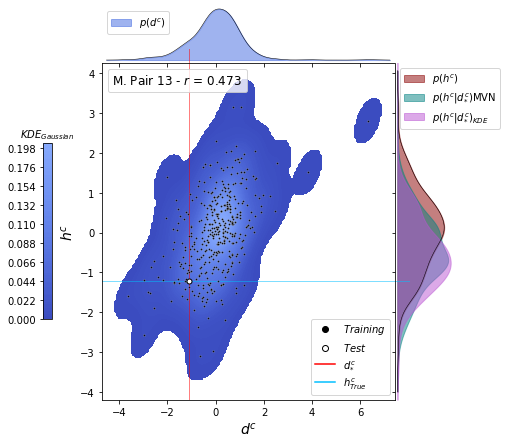

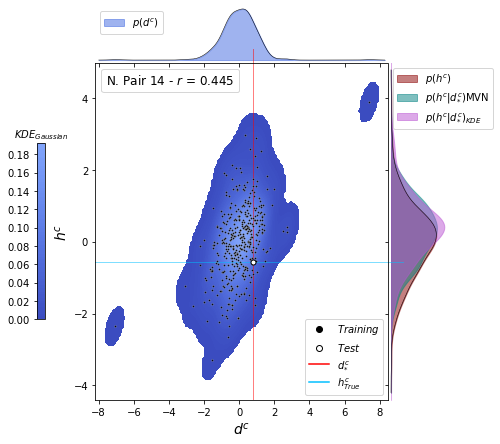

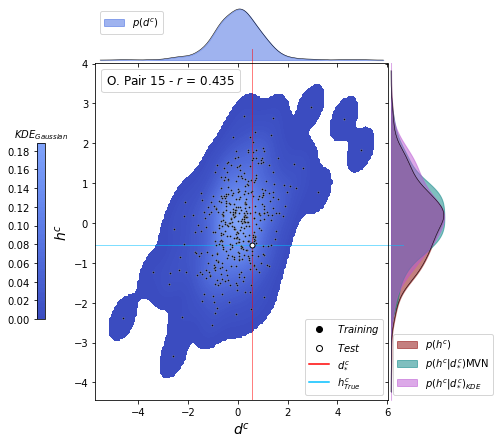

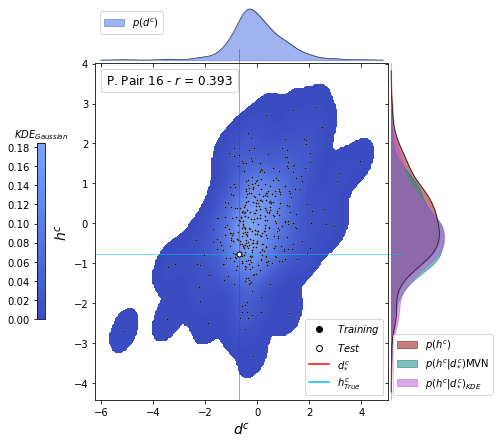

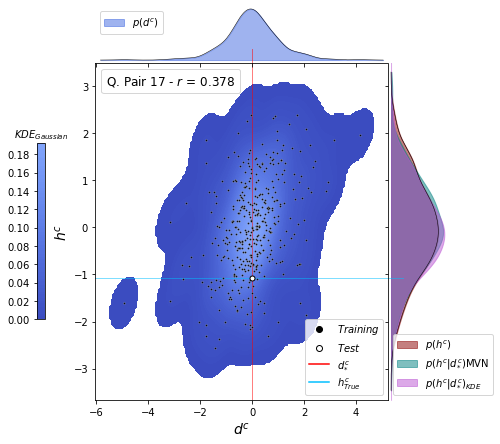

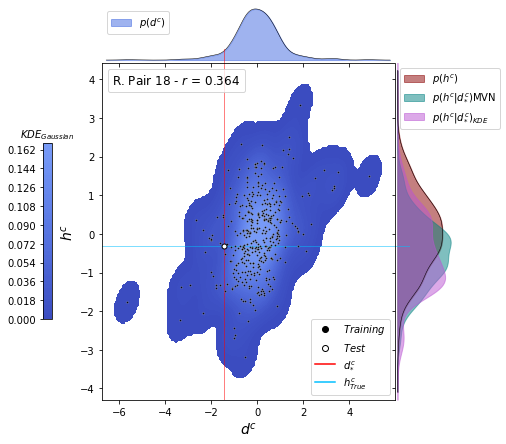

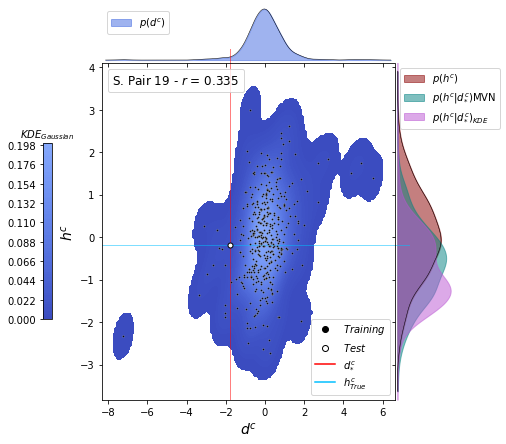

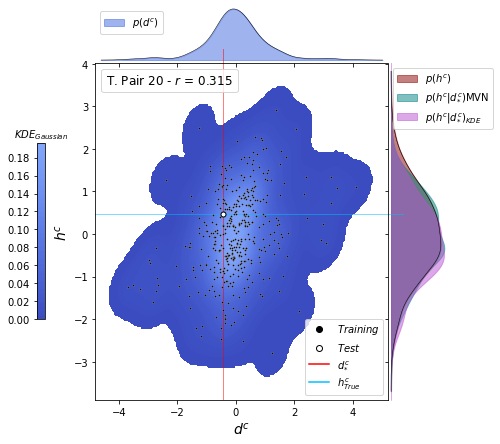

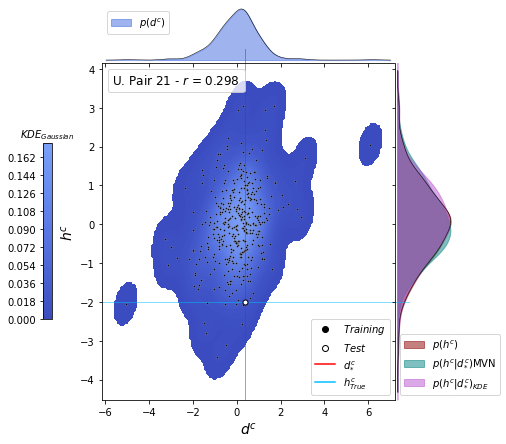

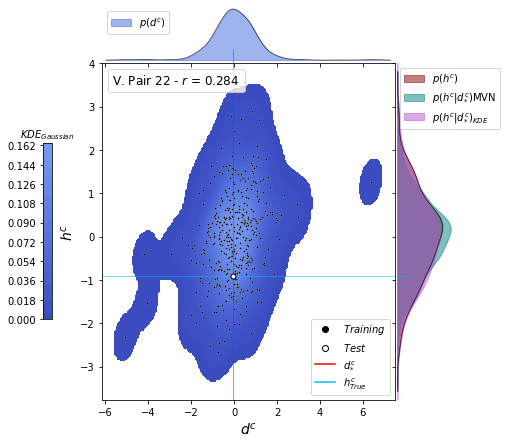

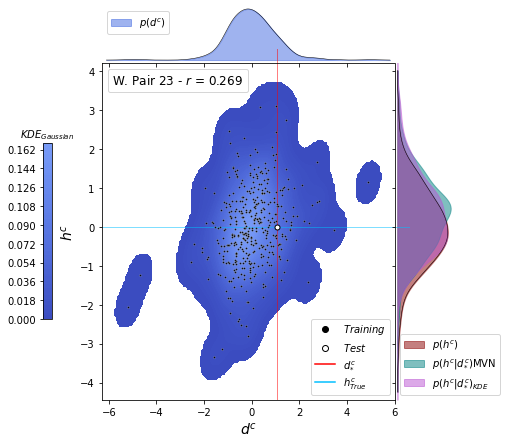

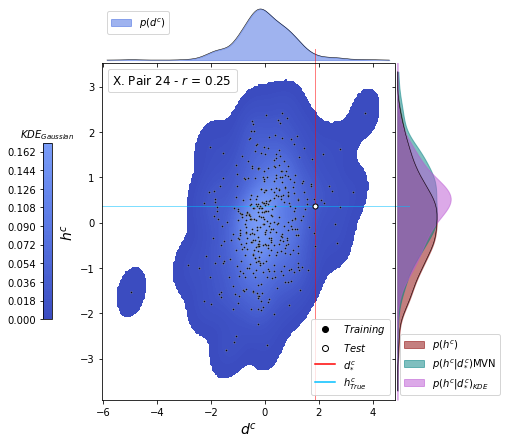

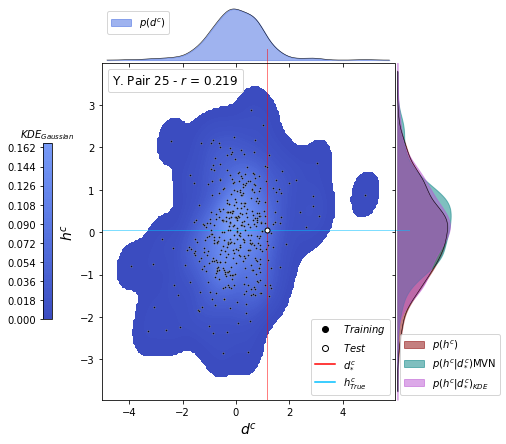

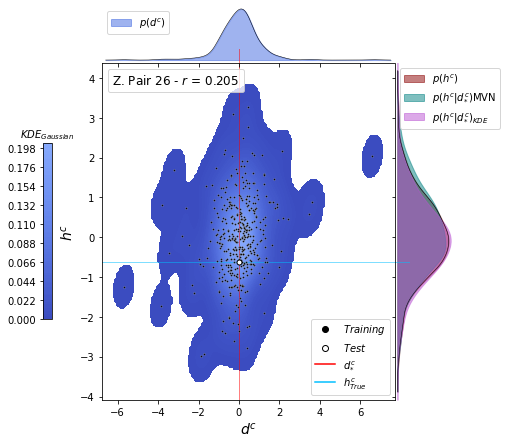

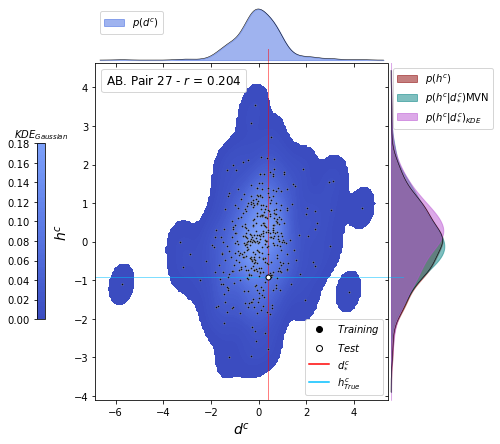

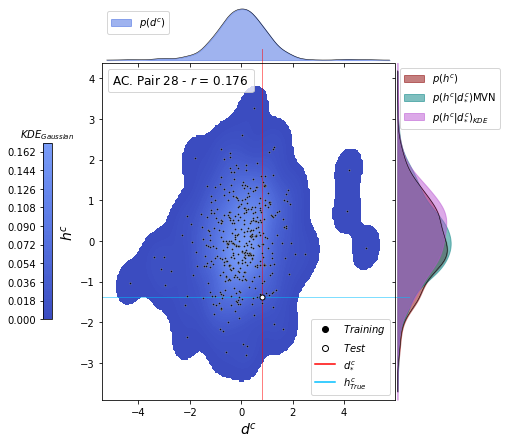

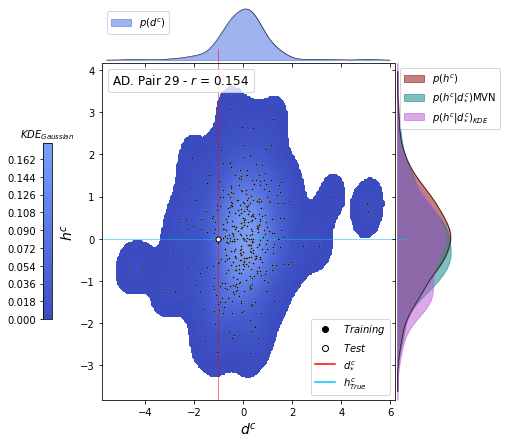

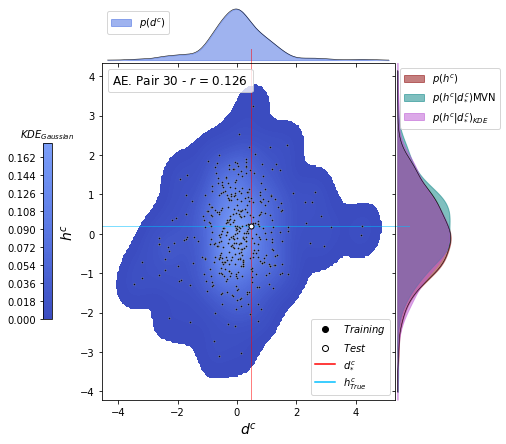

In [12]:
cca_vision(bel=model, Y_obs=y_test, fig_dir=fig_cca_dir, show=True)